This code is for plotting using the full model domain rather than slong specific inline or crossline sections. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
import collections
import copy 
import warnings
import scipy.integrate as integrate
import PIL
from xml.dom import minidom
from shapely.geometry import Polygon, MultiPolygon
#from descartes import PolygonPatch
#from PIL import Image
from scipy.spatial import distance
from scipy import signal
from scipy import interpolate
from scipy.stats import variation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from celluloid import Camera
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#plt.style.use('seaborn-white')

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

%matplotlib inline
#%matplotlib qt
#%matplotlib notebookv
#from google.colab import drive
#drive.mount("/content/gdrive")

Make new cmap from StratBuilder Code

In [2]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcol.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def make_cmap(colors, position=None, bit=False):

    if len(position) != len(colors):
        sys.exit('position length must be the same as colors')
    elif position[0] != 0 or position[-1] != 1:
        sys.exit('position must start with 0 and end with 1')
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):

        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

        cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)

    return cmap

## load source xml file
xmldoc = minidom.parse('/Volumes/SAF_Data/Python/colourmaps/mellow-rainbow.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

mycmap = make_cmap(color_vals,data_vals) ##this is the main rainbow colourmap to be used in the code
print('converted successfully!')

def reverse_colourmap(cmap, name = 'my_cmap_r'):
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

timesteps_r = reverse_colourmap(mycmap)

converted successfully!


In [3]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)

In [4]:
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','069af3', '0e87cc', '2242c77', '0504aa', '00035b'] 
#test = ['00035b', '0504aa', '2242c77', '0e87cc', '069af3', '7bc8f6','cb7723','af884a', 'bd6c48', 'a75e09']
centrelines = ['ffffff', '000000']


In [6]:
##### Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m

thot_SS = 802800 #
#time from which we restarted the runs to add a flood
fldstart_s = 0 ##start time of flood in seconds
variabd = int(input('Enter DV flag')) #flag for if in variable discharge regime
fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}-ud.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

print(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)



Enter DV flag 60


/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-ud.npy


In [11]:
iloc = 800#location of the section along i axis
jloc = 14#location of the secion along j axis


cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

savefilesto = '/Volumes/SAF_Data/NAYS2DH_files/Plots/'
modelrun = f'{nickname}-hr-{idf}-{iloc}'

In [12]:
##define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

print('Shape of the datamaster dataset is: ', datamaster.shape)

Shape of the datamaster dataset is:  (26026, 11, 382)


In [13]:
print(savefilesto)

/Volumes/SAF_Data/NAYS2DH_files/Plots/


In [14]:
num_timesteps = datamaster.shape[2] ## or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ##when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ##flood starttime, s

print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  382
Shape of data used to plot: (26026, 11, 382)


## Calculate sediment supply across the channel 
(bedload flux using MPM and tcrit parameterisation from Lamb et al., 2008)

In [14]:
## create time series of data at input
#crop data
remove_ilocs = np.where(datamaster[:, 0, :] != 1)
ch_head = np.delete(datamaster, remove_ilocs[0], axis=0)
print('Cropped, final dataset shape: ', ch_head.shape)

#sort in cross stream direction from rightbank to left bank
#test = np.empty_like(datamaster)    
for i in range (0, num_timesteps):
    ch_head[:, :, i] = ch_head[:, :, i][np.argsort(ch_head[:, :, i][:, 3])]
    #print(i, data[:, 3, i])
## depth in column4, velocity in column 10 (py idx)

Cropped, final dataset shape:  (26, 11, 310)


In [15]:
n = 0.012 ##mannings
rhow = 1000
rhos = 2650 ##kgm3
sg = (rhos-rhow)/rhow
S = 0.013
g = 9.81
d50 = 0.31e-3 ##d50 in m
tcrit = 0.15*S**0.25
print('Critical shield stress', tcrit)

Critical shield stress 0.05064972563077771


In [16]:
shields = n**2*np.power(ch_head[:, 10, :], 2)/(sg*d50*np.power(ch_head[:, 4, :], 1/3))
dx = np.subtract(ch_head[1:, 3, :], ch_head[:-1, 3, :]) ##dx is constant = 4, at channel head
dx = np.insert(dx, [0], np.ones_like(dx[0, :])*4, axis = 0)
qb_head_cellular = (8*(np.sign(shields-tcrit) * (np.abs(shields-tcrit)) ** (1.5))*(sg*g*d50**3)**0.5)/(1/(interval_to_plot*3600))
qb_head_int = np.empty([1, end_t])
for i in range (0, end_t):
    qb_head_int[0, i] = np.trapz(qb_head_cellular[:, i], ch_head[:, 3, i], dx = dx[:, i])

In [17]:
Qb_pfeiff = ((((1.339-0.05)**1.5)*8)*2.196e-5)/(1/7200)
fluxes = np.array([0.6e6, 0.3e6, 0.1e6, 4.9e6])
flux_con = fluxes/4380 ##convert to m3/2hr
print(flux_con)

[ 136.98630137   68.49315068   22.83105023 1118.72146119]


In [18]:
ch_head[:, 3, :].shape

(26, 310)

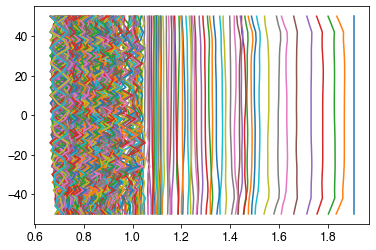

In [21]:
plt.plot(qb_head_cellular, ch_head[:, 3, :]);

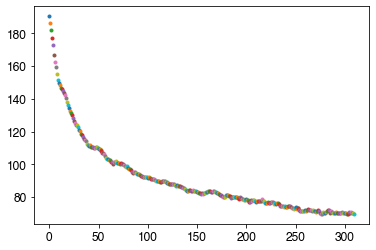

In [22]:
plt.plot(np.reshape(np.arange(0, end_t),[1, 310]), qb_head_int, marker = '.');

In [23]:
## okay just taking the mean sediment supply
qb_mean = np.average(qb_head_int)
print('Mean sediment supply at the inlet, m2/2hr: ', qb_mean)

Mean sediment supply at the inlet, m2/2hr:  90.88874771900757


In [24]:
trueflow = np.empty([datamaster.shape[0], 1, datamaster.shape[2]])
flowvel = np.empty([datamaster.shape[0], 1, datamaster.shape[2]])
for t in range (0, datamaster.shape[2]):
    trueflow[:, 0, t] = datamaster[:, 4, t]
    flowvel[:, 0, t] = datamaster[:, 10, t]


In [25]:
n = 0.012 ##mannings
rhow = 1000
rhos = 2650 ##kgm3
sg = (rhos-rhow)/rhow
S = 0.013
g = 9.81
d50 = 0.31e-3 ##d50 in m
tcrit = 0.15*S**0.25
print('Critical shield stress', tcrit)

num = (n**2)*np.power(flowvel, 2)
den = sg*d50*np.power(trueflow, 1/3)
shields = np.true_divide(num, den, where = den !=0)

qb = (8*(np.sign(shields-tcrit) * (np.abs(shields-tcrit)) ** (1.5))*(sg*g*d50**3)**0.5)/(1/7200)

Critical shield stress 0.05064972563077771


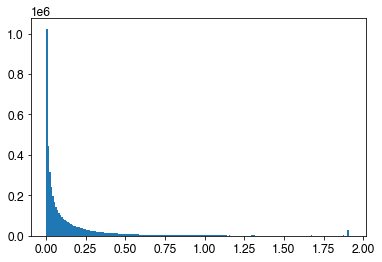

In [26]:
plt.hist(qb.ravel(), bins = 200, range = (0, np.quantile(qb, .99)));

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_90008/2088263567.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.reshape(datamaster[:, 2, 295], (gridy, gridx)),
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_90008/2088263567.py:1: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(np.reshape(datamaster[:, 2, 295], (gridy, gridx)),


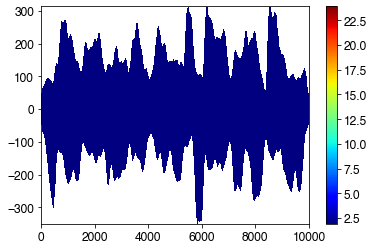

In [27]:
plt.pcolormesh(np.reshape(datamaster[:, 2, 295], (gridy, gridx)), 
                            np.reshape(datamaster[ :, 3, 295] , (gridy, gridx)), 
                            np.reshape(qb[:, :, 295], (gridy, gridx)),
                            cmap = 'jet', norm = mcol.Normalize(vmin=np.quantile(qb, 0.99)), vmax = np.quantile(qb, 1),shading = 'flat', alpha = 1)
plt.colorbar()

In [28]:
np.quantile(qb, 0.99999)

8.443908818315888

In [30]:
np.where(qb>np.quantile(qb, 0.99999));

30.24591485002634


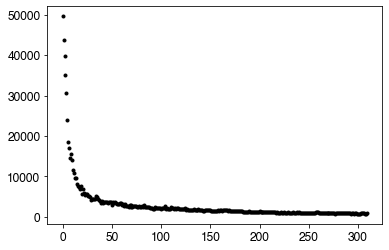

In [31]:
over = np.where(qb>np.quantile(qb, .99999))[0]
#plt.plot(datamaster[:, 2, 220][over], datamaster[:, 3, 220][over], lw = 0, marker = '.')
#for i in over:
#    plt.axvline(i, c = 'r')
for i in range (0, end_t):
    plt.plot(i, np.trapz(qb[:, :, i].ravel()), 'k.')
bedloadflux = np.trapz(qb[qb<np.quantile(qb, 0.9)].ravel())
print(bedloadflux/7200)

## Set up the meshgrid to plot the surface

Just a check to set the colorbar 

func = interpolate.interp2d(xdomain, ydomain, elev, kind = 'cubic')
newelev = 

In [32]:
## find the indices for preflood and post flood

pref_idx = int(np.floor(fldstart)) ##index of time at pre flood
post_idx = int(np.floor((((thot_SS+fldstart_s)/3600)+fldlength)/interval_to_plot)) ##index of time at post flood

print("Flood start at timestep: ", pref_idx)
print("Flood ends at: ", post_idx)

Flood start at timestep:  111
Flood ends at:  111


/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


attribute top: 0.68. Midpoint: 0.44
0.0 5.03200095133


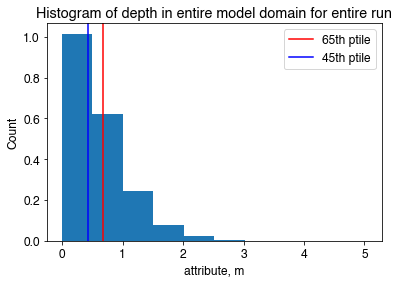

In [33]:
#create 2D grid
#extract elevation

char = 10 ## what do you want to colour by? flow depth (4), elevation change (7) etc
attribs = datamaster[:, char, :].ravel() # scaling to find your normalisation for the attribute/char you choose to colour with
avattribs = np.average(attribs)
locd = np.average(avattribs)
scd = np.std(avattribs)
attx = np.linspace(attribs.min(), attribs.max())
apdf = stats.norm.pdf(attx, locd, scd)
plt.hist(attribs, density=True);

toplim = np.quantile(attribs, 0.65)
#toplim = attribs.max()
lowlim = np.quantile(attribs, 0.45)
#lowlim = 0.1
plt.axvline(toplim, c = 'r', label = '65th ptile')
plt.axvline(lowlim, c = 'b', label = '45th ptile')
plt.xlabel('attribute, m')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram of depth in entire model domain for entire run');
print(f'attribute top: {np.round(toplim, 2)}. Midpoint: {np.round(lowlim, 2)}')
post_idx = -1

xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
#elev_final = np.reshape(datamaster[:, char, -1], (gridy, gridx)) ##using flow depth to plot
#elev_pref = np.reshape(datamaster[:, char, pref_idx], (gridy, gridx)) ##using flow depth to plot
elev_postf = np.reshape(datamaster[:, char, post_idx], (gridy, gridx)) ##using flow depth to plot

llim = datamaster[:, 3, :].min()
ulim = datamaster[:, 3, :].max()

#find the max and min of the variable you're plotting to scale the colourmap
var_llim = datamaster[:, char, :].min() 
var_ulim = datamaster[:, char, :].max()
print(var_llim, var_ulim)


In [34]:
class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#normalise = plt.Normalize(-1, 2)
#midnorm = MidpointNormalize(vmin=-np.quantile(datamaster[:, 4, :], 0.1), vcenter=0.5, vmax=np.quantile(datamaster[:, 4, :], 0.99))
#midnorm = MidpointNormalize(vmin=0, vcenter=np.quantile(datamaster[:, char, :], .25), vmax=np.quantile(datamaster[:, char, :], .999)) 
midnorm = MidpointNormalize(vmin=0, vcenter=lowlim, vmax=toplim) 


0.0 5.03200095133


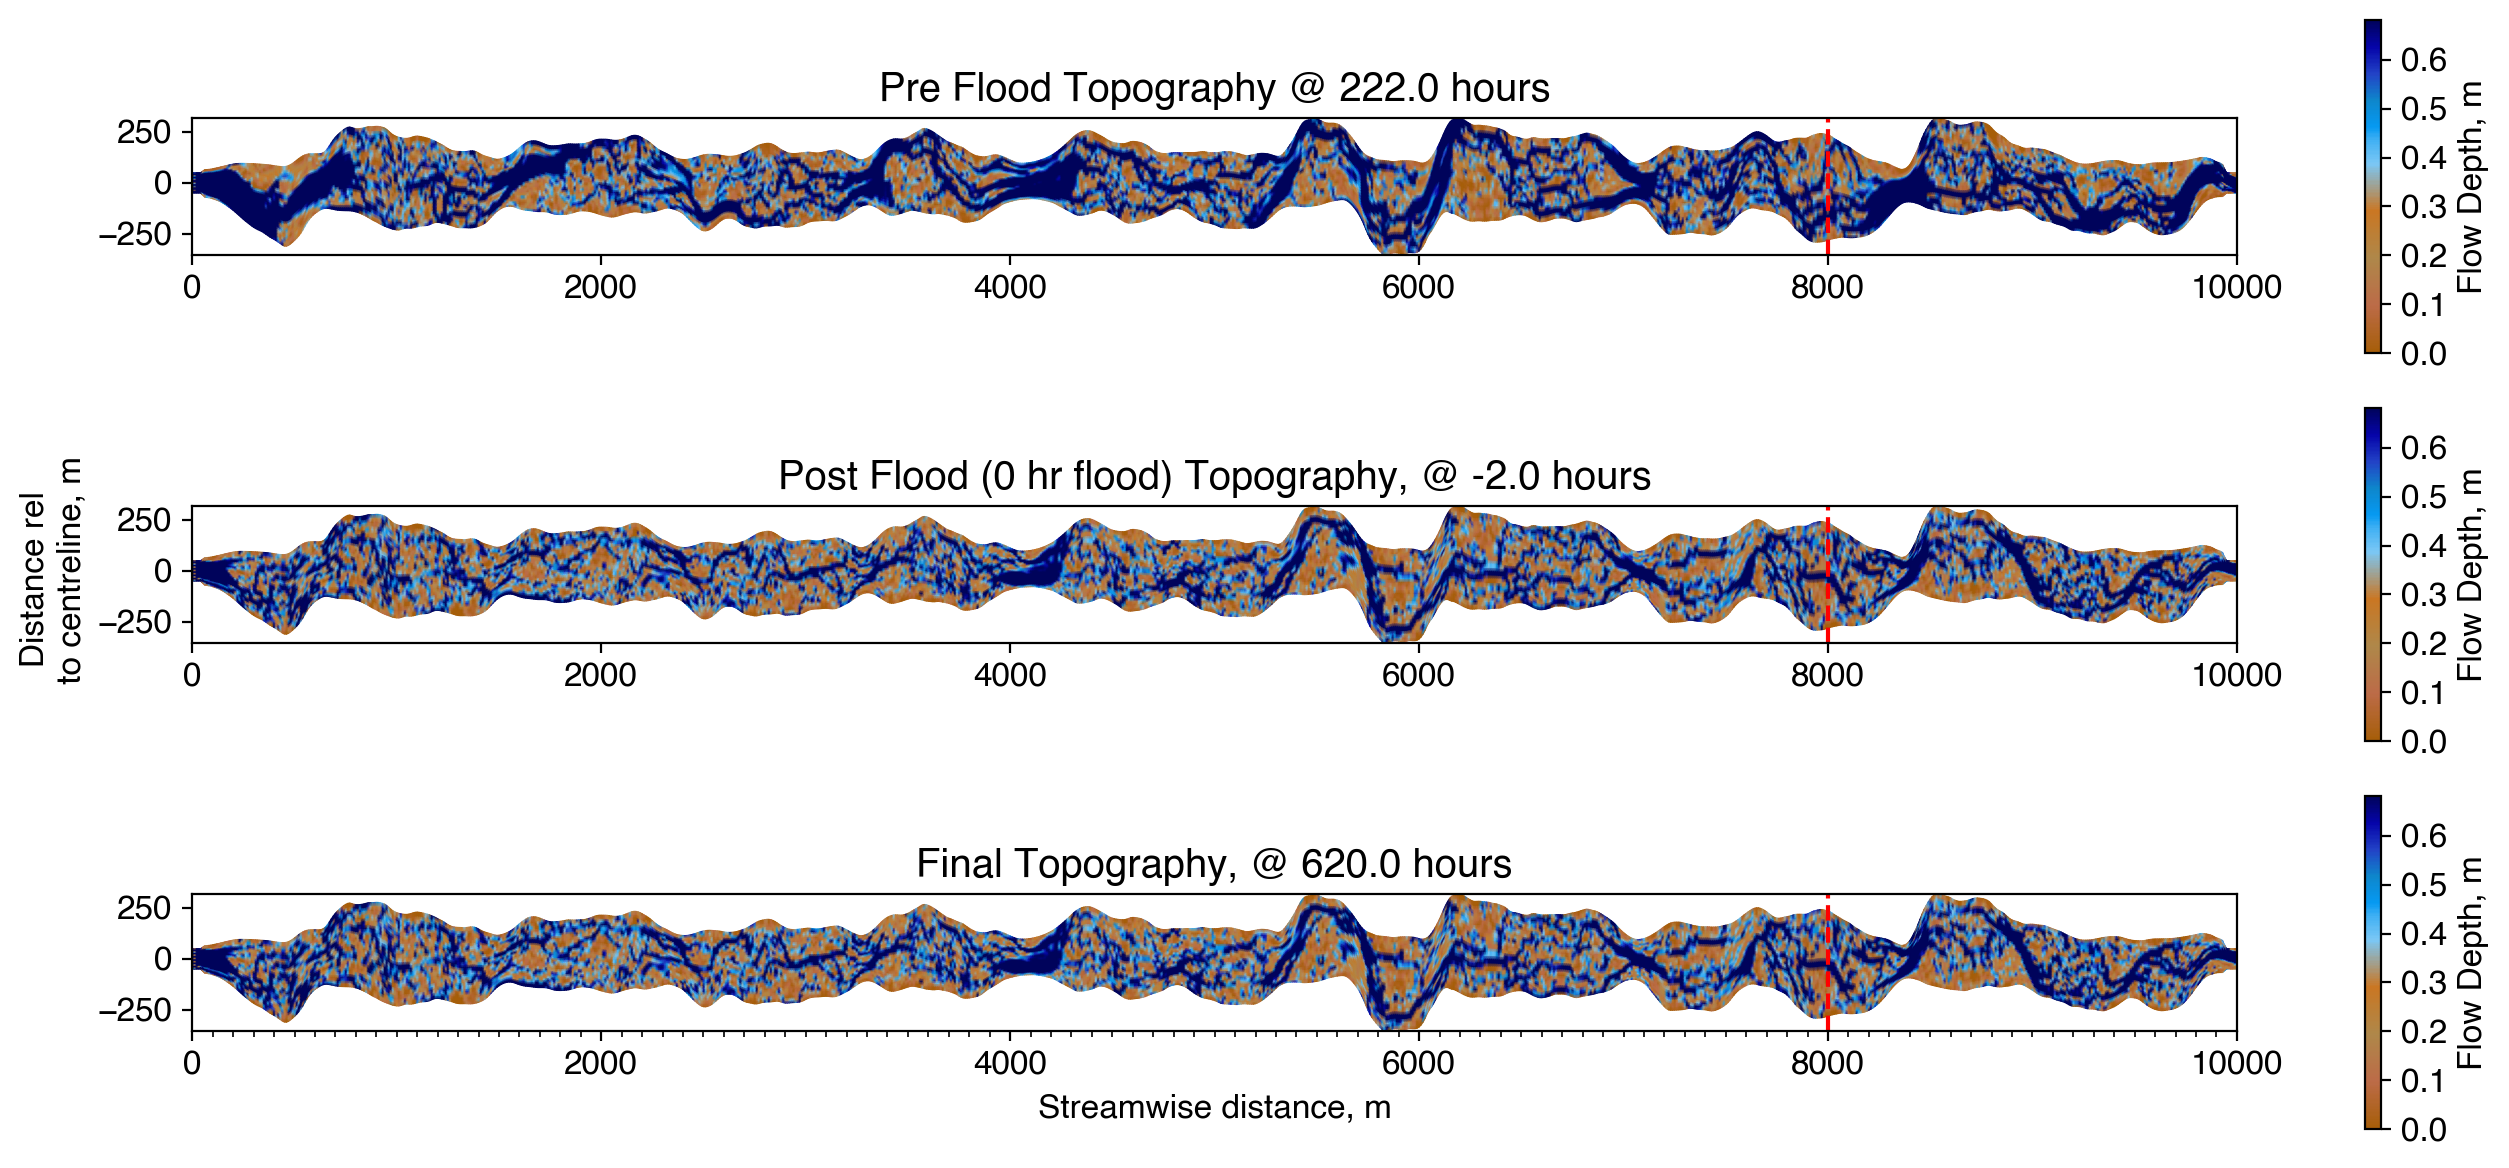

In [35]:
#create 2D grid
#extract elevation

xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
elev_final = np.reshape(datamaster[:, char, -1], (gridy, gridx)) ##using flow depth to plot
elev_pref = np.reshape(datamaster[:, char, pref_idx], (gridy, gridx)) ##using flow depth to plot
elev_postf = np.reshape(datamaster[:, char, post_idx], (gridy, gridx)) ##using flow depth to plot

llim = datamaster[:, char, :].min()
ulim = datamaster[:, char, :].max()

#find the max and min of the variable you're plotting to scale the colourmap
var_llim = datamaster[:, char, :].min() 
var_ulim = datamaster[:, char, :].max()
print(var_llim, var_ulim)

#midnorm = MidpointNormalize(vmin=attribs.min(), vcenter=1, vmax=toplim) 

fig, ax = plt.subplots(3, figsize = (14, 6), tight_layout = True, dpi = 200)
fig.subplots_adjust(hspace=.1)

ax[1].set_ylabel('Distance rel \n to centreline, m')
ax[-1].set_xlabel('Streamwise distance, m')

ax[0].set_title(f'Pre Flood Topography @ {pref_idx*interval_to_plot} hours')
ax[1].set_title(f'Post Flood ({fldlength} hr flood) Topography, @ {post_idx*interval_to_plot} hours')
ax[-1].set_title(f'Final Topography, @ {end_t*interval_to_plot} hours')

ax[0].axvline(xsloc, c = 'r', ls = '--')
ax[1].axvline(xsloc, c = 'r', ls = '--')
ax[-1].axvline(xsloc, c = 'r', ls = '--')
dat_pref = ax[0].pcolormesh(xdomain, ydomain, elev_pref,cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
#dat_pref = ax[0].contourf(xdomain, ydomain, elev_pref,cmap = get_continuous_cmap(test), norm = midnorm, levels = 50)#, shading = 'gouraud', alpha = .8)
dat_postf = ax[1].pcolormesh(xdomain, ydomain, elev_postf, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
dat_final = ax[-1].pcolormesh(xdomain, ydomain, elev_final, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)

fig.colorbar(dat_pref, ax = ax[0], label = 'Flow Depth, m')
fig.colorbar(dat_postf, ax = ax[1], label = 'Flow Depth, m')
fig.colorbar(dat_final, ax = ax[-1], label = 'Flow Depth, m')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[-1].set_aspect('equal')
ax[-1].xaxis.set_minor_locator(MultipleLocator(100))
#ax[0].set_xlim(500, 4500)
#ax[0].set_facecolor('xkcd:midnight blue')
#ax[1].set_facecolor('xkcd:midnight blue')
#ax[-1].set_facecolor('xkcd:midnight blue')
#plt.savefig(f'{savefilesto}planformchange/PF{modelrun}.png', dpi=100)

#plt.close(fig)

In [9]:
## generate just a regular planform map
#with plt.style.context('dark_background'):
fig = plt.figure(figsize = (15, 5), tight_layout = True, frameon=False)
planform = plt.pcolormesh(xdomain, ydomain, elev_final,cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
plt.ylabel('Distance relative \nto centreline, m')
plt.xlabel('Streamwise distance')
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.set_aspect('equal')
ax.set_facecolor('w')
fig.colorbar(planform, ax = ax, label = 'Flow velocity, m/s', shrink = 1, pad = 0.05, aspect = 5)

#plt.savefig(f'{savefilesto}planformchange/PF{modelrun}.png', dpi=192)
plt.close()

NameError: name 'xdomain' is not defined

<Figure size 1080x360 with 0 Axes>

Time series snapshot of the channel, also kinda useless, maybe useful with facies?

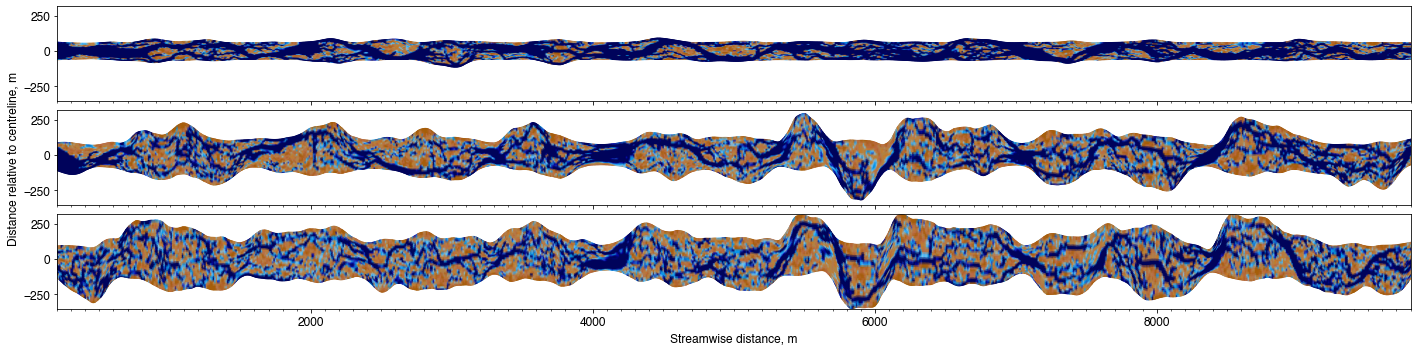

In [37]:
#%matplotlib notebook
## create a series of snapshots of the channel reach 

numplots = 3 #we want 5 sublots
fig, ax = plt.subplots(3, figsize = (20, 5), sharex=True, sharey=True, tight_layout=True, squeeze=True)
fig.subplots_adjust(hspace=.1)

ax[0].set_ylim(ydomain.min(), ydomain.max())

ax[0].set_xlim(200, 9800)
ax=ax.ravel()

for a, ts in enumerate(np.linspace(10, end_t-1, numplots, dtype=int)):
    dat = ax[a].pcolormesh(np.reshape(datamaster[:, 2, ts], (gridy, gridx)), 
                     np.reshape(datamaster[:, 3, ts], (gridy, gridx)),
                     np.reshape(datamaster[:, char, ts], (gridy, gridx)),
                     cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
    ax[a].set_aspect('equal')
    #ax[a].set_title(f'Timestep: {int(ts*interval_to_plot)}')
    #ax[a].axvline(xsloc, c='r',ls = '--')
    ax[a].xaxis.set_minor_locator(MultipleLocator(100))
#plt.colorbar(dat, ax = ax[1])
ax[-1].set_xlabel('Streamwise distance, m');
ax[1].set_ylabel('Distance relative to centreline, m');
# plt.savefig(f'{savefilesto}timeseries/fd-{modelrun}.png', dpi = 300)

In [15]:
profiles = np.zeros([gridx, 7, end_t])

#xposition, right bank, leftbank, width, widening rate
profiles[:, 0, :] = datamaster[:gridx, 2, :] #get the x locations
profiles[:, 1, :] = datamaster[:gridx, 3, :] #get the right bank locations
profiles[:, 2, :] = datamaster[-gridx:, 3, :] #get the left bank locations

for i in range(profiles.shape[2]):
    profiles[:, 3, i] = profiles[:, 2, i]-profiles[:, 2, 0] #right bank displacement
    profiles[:, 4, i] = profiles[:, 1, i]-profiles[:, 1, 0] #left bank displacement
    
profiles[:, 5, 1:] = (abs(profiles[:, 3, 1:])-abs(profiles[:, 3, :-1]))/interval_to_plot
profiles[:, 6, 1:] = (abs(profiles[:, 4, 1:])-abs(profiles[:, 4, :-1]))/interval_to_plot


In [16]:
np.save('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/channel-profile-ud.npy', profiles)

In [14]:
savefilesto

'/Volumes/SAF_Data/NAYS2DH_files/Plots/'

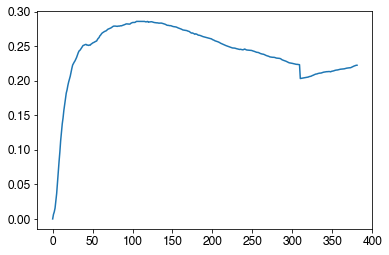

In [13]:
widthdist = profiles[:, 2, :]-profiles[:, 1, :]
#plt.plot(np.average(widthdist, axis=0));
plt.plot(variation(widthdist, axis=0))

#plt.hist(profiles[:, 5, :].ravel());
#plt.hist(profiles[:, 6, :].ravel(), histtype = 'step');

In [ ]:
np.save()

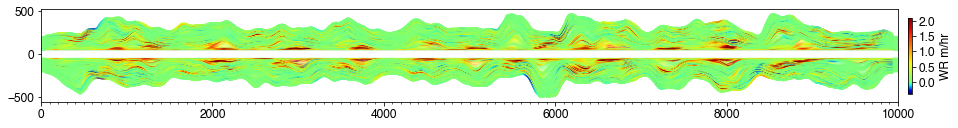

In [22]:
#widenorm = mcol.Normalize(vmin=np.quantile(profiles[:, 5:, :],0.005), vmax=np.quantile(profiles[:, 5:, :], 0.99)) 
widenorm = MidpointNormalize(vmin=np.quantile(profiles[:, 5:, :],0.005), vcenter = 0, vmax=np.quantile(profiles[:, 5:, :], 0.99)) 
fig, ax = plt.subplots(figsize = (15, 3), tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(profiles[:, 0, :].min(), profiles[:, 0, :].max())
for i in range (0, end_t):
    wrrb = plt.scatter(profiles[:, 0, i], profiles[:, 1, i]-(0.5*i), c = profiles[:, 5, i], cmap = 'jet', norm=widenorm, s = .05);
    wrlb = plt.scatter(profiles[:, 0, i], profiles[:, 2, i]+(0.5*i), c = profiles[:, 6, i], cmap = 'jet', norm=widenorm, s = .05);
if variabd == 1:
    plt.plot(profiles[:, 0, pref_idx], profiles[:, 1, i]-(0.5*pref_idx), 'k', lw = 1)
    plt.plot(profiles[:, 0, pref_idx], profiles[:, 2, i]+(0.5*pref_idx), 'k', lw = 1)
fig.colorbar(wrrb, ax = ax, label = 'WR m/hr', pad = 0.01, shrink=0.4);
ax.xaxis.set_minor_locator(MultipleLocator(100))

#plt.savefig(f'{savefilesto}widths/WRFD{modelrun}.png', dpi = 300)

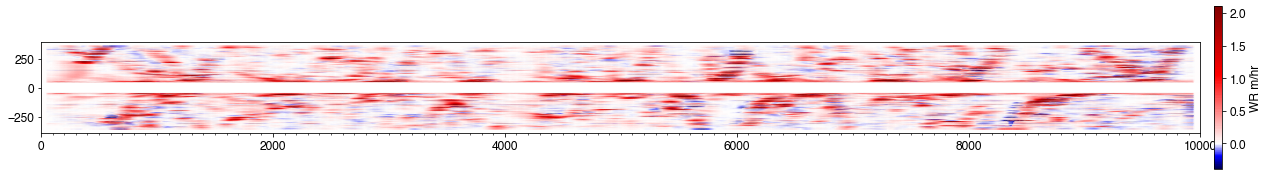

In [23]:
fig, ax = plt.subplots(figsize = (20, 6), tight_layout=True)
ax.set_aspect('1')
ax.set_xlim(profiles[:, 0, :].min(), profiles[:, 0, :].max())
for i in range (0, end_t):
    wrrb = plt.scatter(profiles[:, 0, 0], profiles[:, 1, 0]-(i), c = profiles[:, 5, i], cmap = 'seismic', norm=widenorm, s = .1, marker = ".");
    wrlb = plt.scatter(profiles[:, 0, 0], profiles[:, 2, 0]+(i), c = profiles[:, 6, i], cmap = 'seismic', norm=widenorm, s = .1, marker = '.');
if variabd == 1:
    plt.plot(profiles[:, 0, pref_idx], profiles[:, 1, i]-(0.5*pref_idx), 'k', lw = 1)
    plt.plot(profiles[:, 0, pref_idx], profiles[:, 2, i]+(0.5*pref_idx), 'k', lw = 1)
fig.colorbar(wrrb, ax = ax, label = 'WR m/hr', pad = 0.01, shrink=0.4);
ax.xaxis.set_minor_locator(MultipleLocator(100))

#plt.savefig(f'{savefilesto}widths/WRFD{modelrun}.png', dpi = 300)

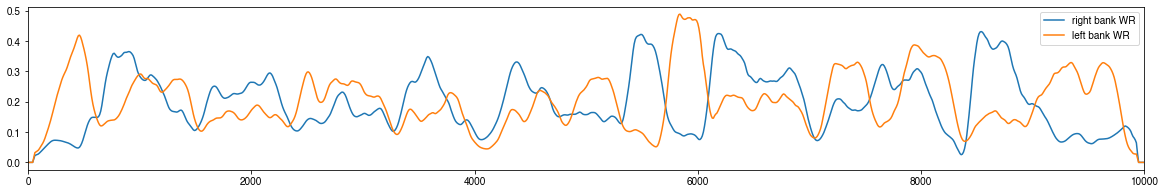

In [92]:
avgwid = np.mean(profiles[:, 5:, :], axis = 2)
plt.figure(figsize = (20, 3))
plt.plot(profiles[:, 0, 0], avgwid[:, 0], label = 'right bank WR')
plt.plot(profiles[:, 0, 0], avgwid[:, 1], label = 'left bank WR')
plt.xlim(0,10000)
plt.legend()

In [24]:
# Make a user-defined colormap.
tim = np.arange(0, end_t)
cm1 = mycmap
cnorm = mcol.Normalize(vmin=min(tim),vmax=max(tim))

# Turn these into an object that can be used to map time values to colors and can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=timesteps_r) 
cpick.set_array([])

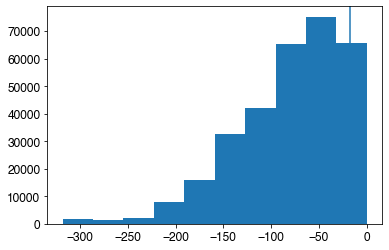

In [25]:
## create mask where widening rate is a specific value
plt.hist(profiles[:, 4, :].ravel())
toshow = np.quantile(profiles[:, 4, :].ravel(), 0.9)
plt.axvline(toshow)

bigwidening_rb = np.ma.masked_where(profiles[:, 4, :] < toshow, profiles[:, 1, :], copy = True)
bigwidening_lb = np.ma.masked_where(profiles[:, 4, :] < toshow, profiles[:, 2, :], copy = True)
bigwidening_x = np.ma.masked_where(profiles[:, 4, :] < toshow, profiles[:, 0, :], copy = True)

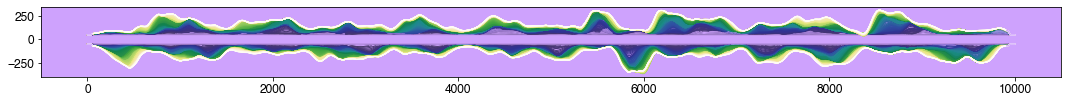

In [26]:
fig = plt.figure(figsize = (15, 5), tight_layout = True)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_facecolor('xkcd:lilac')
for i in range (0, end_t):
    rb = plt.plot(profiles[:, 0, i], profiles[:, 1, i], c = cpick.to_rgba(i), lw = 1)
    lb = plt.plot(profiles[:, 0, i], profiles[:, 2, i], c = cpick.to_rgba(i), lw = 1)
    
    plt.plot(bigwidening_x[:, i], bigwidening_lb[:, i], c = 'xkcd:lilac', lw = 1)
    plt.plot(bigwidening_x[:, i], bigwidening_rb[:, i], c = 'xkcd:lilac', lw = 1)

## Mapping reworking

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_16660/1276155163.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  rew = ax.pcolormesh(xdomain,ydomain, np.reshape(totalreworking, (gridy, gridx)), cmap=bincmap, norm=binnorm, shading='flat')


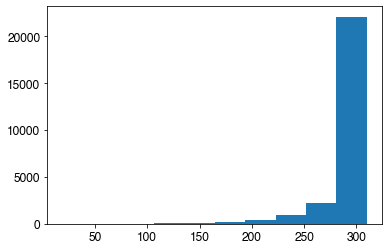

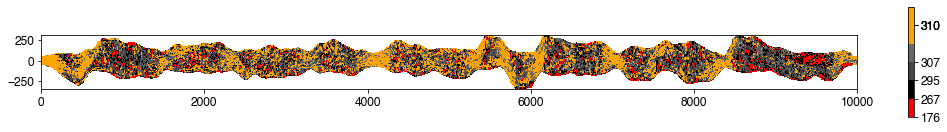

In [27]:
 
## Define threshod for being 'under water'

# for now i will use depth, but I think we should use a shear stress threshold

# find where depth > r_thresh 

r_thresh = 0.05 #threshold for motion/defining channel v not channel. For depth, anything deeper than 5cm is 'channel'

#channel = 1, not channel = 0
binarybed = np.where(datamaster[:, 4, :] > 0.1, 1, 0) #basically making a matrix of binary flags


totalreworking = np.sum(binarybed, axis=1)
plt.figure()
plt.hist(totalreworking);

qtiles = np.quantile(totalreworking, [0.01, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99])
bincmap = mcol.ListedColormap(['red', '#000000','#444444', '#666666', '#ffffff', 'blue', 'orange'])
binnorm = mcol.BoundaryNorm(qtiles, bincmap.N, clip=True)

plt.figure(1)
fig, ax = plt.subplots(1, figsize = (15, 2), tight_layout=True)
ax.set_aspect('equal')
rew = ax.pcolormesh(xdomain,ydomain, np.reshape(totalreworking, (gridy, gridx)), cmap=bincmap, norm=binnorm, shading='flat')
fig.colorbar(rew, ax=ax)

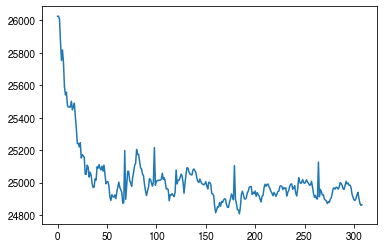

In [28]:
%matplotlib inline
compressrework = copy.deepcopy(binarybed)
for col in range (1, binarybed.shape[1]):
    compressrework[:, col] = binarybed[:, col-1]+ binarybed[:, col]
    compressrework[:, col][np.where(compressrework[:, col]==2)]=1
plt.plot(np.count_nonzero(compressrework[:, :col], axis=0))

## Code block to run reach scale time series evol of the bed

#%matplotlib notebook
## create a series of snapshots of the channel reach 
adjtime = int(input('Enter adjustment timestep: ')) #time taken for the reworking curve to flatten out
#numtimes = int(end_t//adjtime)
numtimes = len(np.arange(10, end_t-1, adjtime))
print(numtimes)
numplots = 10 #we want 5 sublots of the reach
fig, ax = plt.subplots(numtimes, numplots, figsize = (25, 15), sharex=False, sharey=True, tight_layout=True, squeeze=True)
fig.subplots_adjust(hspace=.05, wspace = .1)

ax[0, 0].set_ylim(ydomain.min(), ydomain.max())

ts = np.arange(10, end_t-1, adjtime).astype(int)
for t, ts in zip(np.arange(0, numtimes), ts): 
    start = 0
    stop = 1000
    for p, r in zip(range(0, numplots), np.arange(0, 10000, 1000)):
        ax[t, p].pcolormesh(np.reshape(datamaster[:, 2, ts], (gridy, gridx)), 
                            np.reshape(datamaster[:, 3, ts], (gridy, gridx)),
                            np.reshape(datamaster[:, char, ts], (gridy, gridx)),
                            cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
        ax[t, p].set_aspect('equal')
        ax[t, p].set_title(f'T = {ts*interval_to_plot} hrs')
        ax[t, p].xaxis.set_minor_locator(MultipleLocator(100))
        ax[t, p].set_xlim(start+r, stop+r)
plt.savefig(f'{savefilesto}timeseries/multi-{modelrun}.png', dpi = 500)

## Do Facies Things
Extract an array with depth and velocity data from all timesteps, at all points

In [29]:
temp = 20.0 #temperature in degrees celcius
kv = (1.14-0.031*(temp-15)+0.00068*((temp-15)**2))*10**-6
print(kv)
D_star = np.power((1.65*9.81)/(1e3*(kv**2)), 0.333)*3.1e-4
print(D_star)
d50um = 310
chezy_rough = 18*(np.log10(4*trueflow/d50)) #i think this is log10, else they would've put ln no?

mmp =(p*(flowvel**2))/(1650*(chezy_rough**2)*d50)## modified mobility parameter

1.0019999999999997e-06
0.7770191533135022


/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_16660/1422929164.py:7: RuntimeWarning: divide by zero encountered in log10
  chezy_rough = 18*(np.log10(4*trueflow/d50)) #i think this is log10, else they would've put ln no?


In [30]:
mmp_timestep = copy.deepcopy(mmp)
mmp_reshape= np.reshape(mmp[:, :, :], (gridy, gridx, datamaster.shape[2]))
mmp_reshape.shape

(26, 1001, 310)

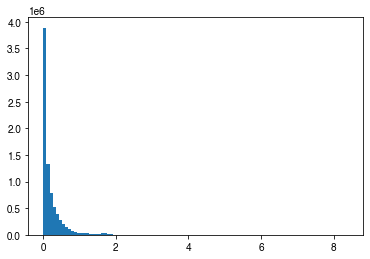

In [31]:
plt.hist(mmp.ravel(), bins = 100);
mmprange = [0, 0.01, 0.025, 0.17, 0.35, 1.5, 10] ## LP, R, D, D-UP, UP #you have to use the zero at the beginning to account for the sub LSPB stuff

In [32]:
if mmp_reshape.max() > 10:
    print('CHECK BINS!!')

In [33]:
xs_freq = np.empty([len(mmprange)-1, mmp_reshape.shape[1]]) 
xs_freq_edges = np.empty([len(mmprange), mmp_reshape.shape[1]])
xs_percents = np.empty_like(xs_freq)
print(xs_freq.shape, xs_freq_edges.shape)
for x in range (0, mmp_reshape.shape[1]):
    
    xs_freq[:, x], xs_freq_edges[:, x] = np.histogram(mmp_reshape[:, x, :].ravel(), bins = mmprange) 
    xs_percents[:, x] = xs_freq[:, x]/(gridy*mmp_reshape.shape[2])
    
ts_freq = np.empty([len(mmprange)-1, num_timesteps])
ts_freq_edges = np.empty([len(mmprange), num_timesteps])
ts_percents = np.empty_like(ts_freq)

print(ts_freq.shape, ts_freq_edges.shape)
for t in range(0, num_timesteps):
    ts_freq[:, t], ts_freq_edges[:, t] = np.histogram(mmp_timestep[:, :, t], bins = mmprange)
    ts_percents[:, t] = ts_freq[:, t]/(gridx*gridy)

(6, 1001) (7, 1001)
(6, 310) (7, 310)


In [34]:
clist = ['xkcd:dark brown','xkcd:mud brown', 'xkcd:shit', 'xkcd:dark tan', 'xkcd:sand', 'xkcd:stone']
cmap_vvfac = ListedColormap(['xkcd:dark brown','xkcd:mud brown', 'xkcd:shit', 'xkcd:dark tan', 'xkcd:sand', 'xkcd:stone'])

#mmprange = [0.01, 0.025, 0.17, 0.35, 1.5, 10] ## LP, R, D, D-UP, UP
norm_vvfac = BoundaryNorm(mmprange, cmap_vvfac.N)

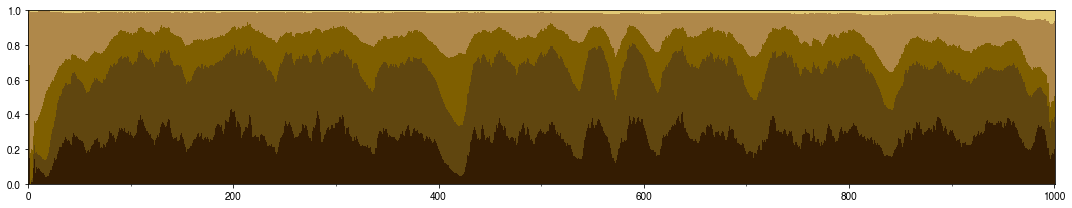

In [35]:
fig = plt.figure(figsize = (15, 3), tight_layout = True)
w = 1
plt.xlim(0, gridx)
plt.ylim(0, 1)
for i in range (0, gridx):
    plt.bar(i, xs_percents[0, i], w, color=clist[0])
for x in range (0, 1001):
    for i in range (1, len(xs_freq)):
        #fac = plt.bar(x, xs_freq[i, x], w, bottom = np.sum(xs_freq[:i, x]), color = clist[i])
        plt.bar(x, xs_percents[i, x], w, bottom = np.sum(xs_percents[:i, x]), color = clist[i-1])
ax=plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(100))

#plt.savefig(f'{savefilesto}facies/facieshist{modelrun}.png', dpi = 300)

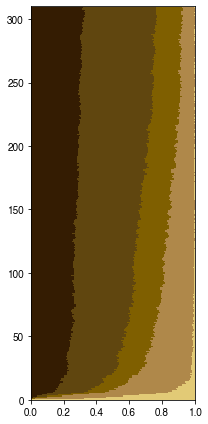

In [36]:
fig = plt.figure(figsize = (3, 6), tight_layout = True)
w = 1
plt.xlim(0, 1)
plt.ylim(0, end_t)
for i in range (0, num_timesteps):
    plt.barh(i, ts_percents[0, i], w, color=clist[0])
for t in range (0, num_timesteps):
    for i in range (1, len(ts_freq)):
        #fac = plt.bar(x, xs_freq[i, x], w, bottom = np.sum(xs_freq[:i, x]), color = clist[i])
        plt.barh(t, ts_percents[i, t], w, left = np.sum(ts_percents[:i, t]), color = clist[i-1])
        
#plt.savefig(f'{savefilesto}facies/facieshist{modelrun}.png', dpi = 300)

In [37]:
reach_raw = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/chan-widths/CW-{datnam}')
reach_raw = reach_raw[:, :, :num_timesteps]
## create array to store the statiistics on the channel width for the full reach 
## This is a end_t x 3 array with min, max and mean reach width
max_chw = reach_raw[:, 2].max(axis=0)
min_chw = reach_raw[:, 2].min(axis=0)
reach_raw = np.concatenate((reach_raw, np.empty([len(reach_raw), 1, end_t])), axis = 1)
print(reach_raw.shape)
for i in range (0, end_t-1):
    reach_raw[:, 3, i] = (reach_raw[:, 2, i+1]-reach_raw[:, 2, i])/interval_to_plot #find and append reach data with widening rate, PER HOUR
    

(990, 4, 310)


0.0 5.03200095133


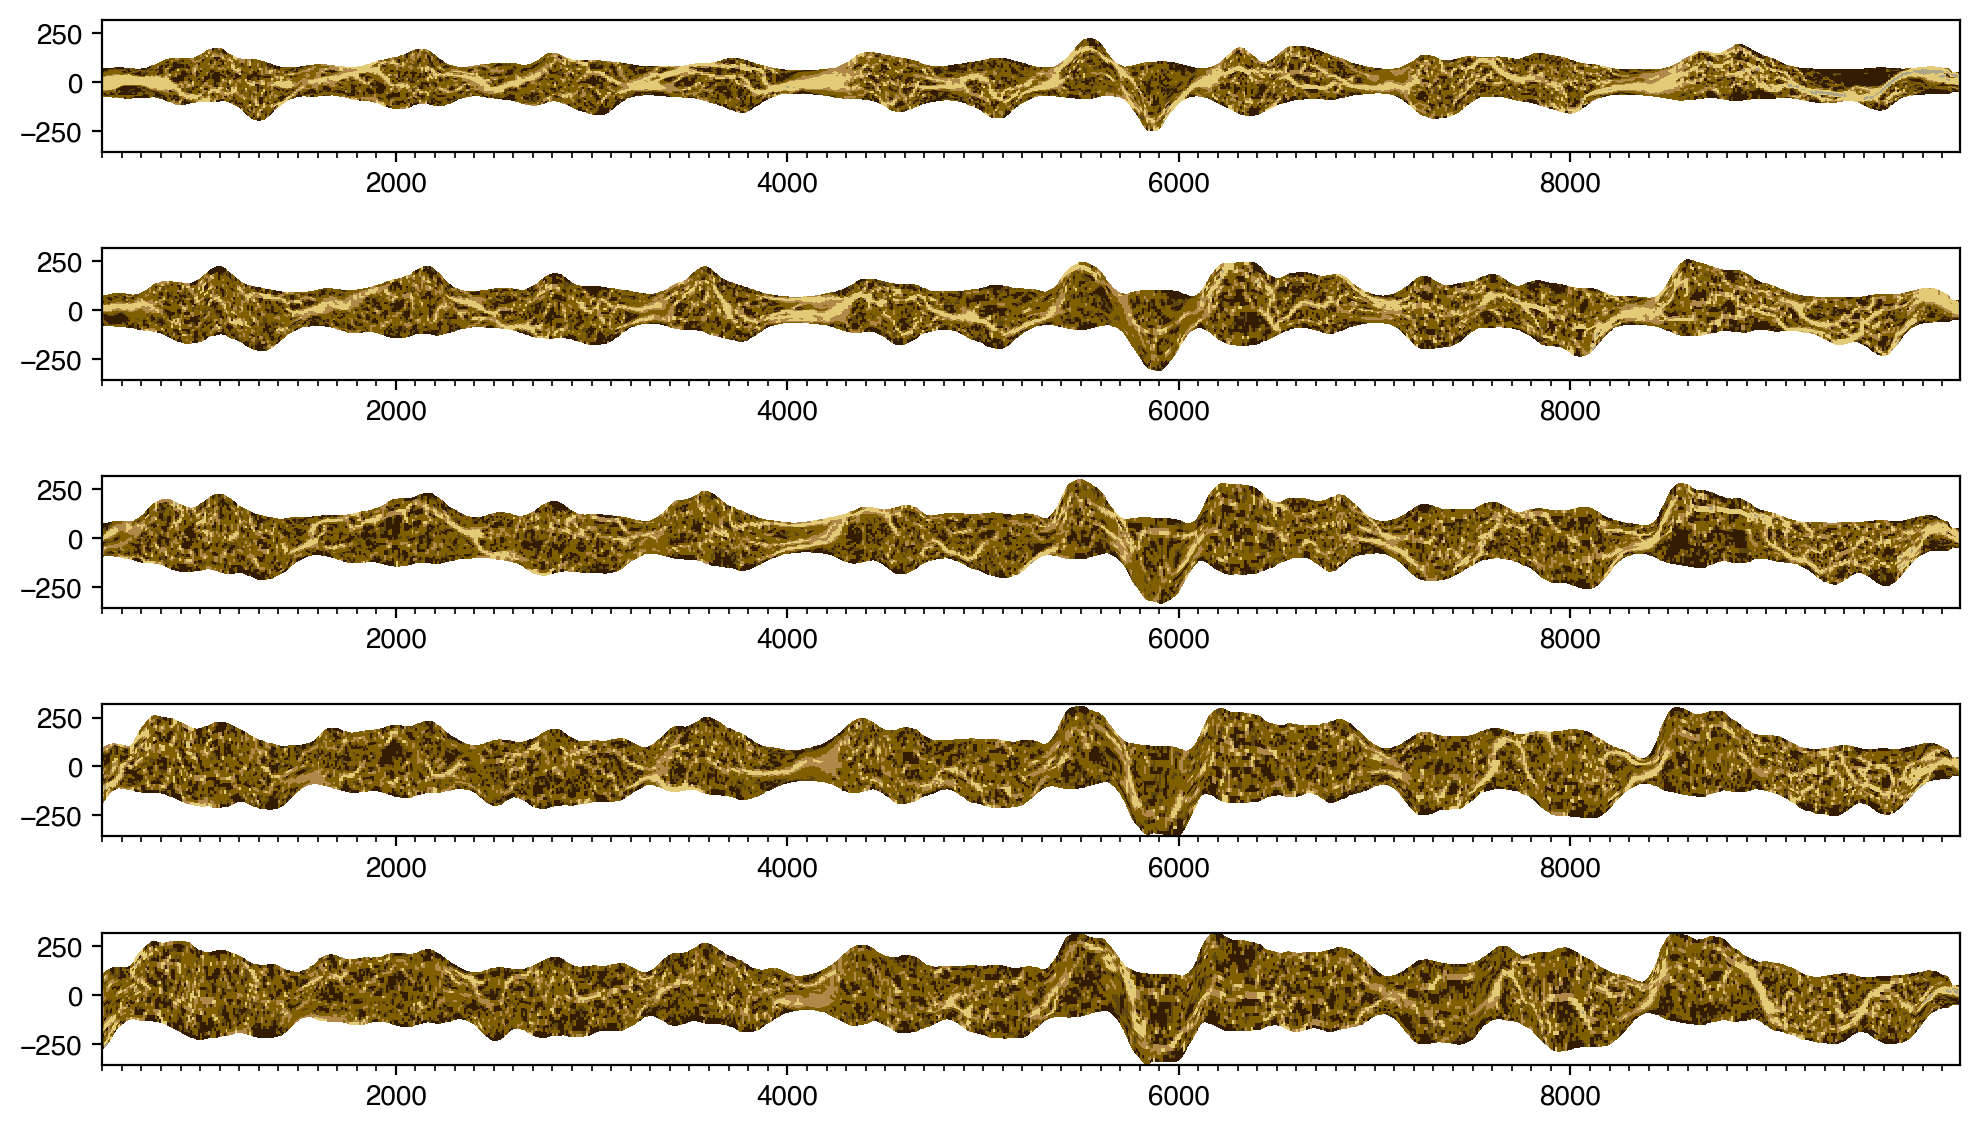

In [38]:
#create 2D grid
#extract elevation
warnings.filterwarnings("ignore")

xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
elev_final = np.reshape(mmp[:, :, -1], (gridy, gridx)) ##using flow depth to plot

llim = datamaster[:, char, :].min()
ulim = datamaster[:, char, :].max()

#find the max and min of the variable you're plotting to scale the colourmap
var_llim = datamaster[:, char, :].min() 
var_ulim = datamaster[:, char, :].max()
print(var_llim, var_ulim)

#midnorm = MidpointNormalize(vmin=attribs.min(), vcenter=1, vmax=toplim) 

fig, ax = plt.subplots(5, figsize = (10, 6), tight_layout = True, dpi = 200, sharey = True)
fig.subplots_adjust(hspace=.1)

# ax[1].set_ylabel('Distance rel \n to centreline, m')
# ax[-1].set_xlabel('Streamwise distance, m')

# ax[0].set_title(f'Pre Flood Topography @ {pref_idx*interval_to_plot} hours')
# ax[1].set_title(f'Post Flood ({fldlength} hr flood) Topography, @ {post_idx*interval_to_plot} hours')
# ax[-1].set_title(f'Final Topography, @ {end_t*interval_to_plot} hours')

# ax[0].axvline(xsloc, c = 'r', ls = '--')
# ax[1].axvline(xsloc, c = 'r', ls = '--')
# ax[-1].axvline(xsloc, c = 'r', ls = '--')
dat_pref = ax[0].pcolormesh(np.reshape(datamaster[:, 2, 64], (gridy, gridx)), 
                            np.reshape(datamaster[ :, 3, 64] , (gridy, gridx)), 
                            np.reshape(mmp[:, :, 64], (gridy, gridx)),
                            cmap = cmap_vvfac, norm = norm_vvfac, shading = 'flat', alpha = 1)
dat_pref = ax[1].pcolormesh(np.reshape(datamaster[:, 2, 129], (gridy, gridx)), 
                            np.reshape(datamaster[ :, 3, 129] , (gridy, gridx)), 
                            np.reshape(mmp[:, :, 129], (gridy, gridx)),
                            cmap = cmap_vvfac, norm = norm_vvfac, shading = 'flat', alpha = 1)
dat_pref = ax[2].pcolormesh(np.reshape(datamaster[:, 2, 184], (gridy, gridx)), 
                            np.reshape(datamaster[ :, 3, 184] , (gridy, gridx)), 
                            np.reshape(mmp[:, :, 184], (gridy, gridx)),
                            cmap = cmap_vvfac, norm = norm_vvfac, shading = 'flat', alpha = 1)
dat_pref = ax[3].pcolormesh(np.reshape(datamaster[:, 2, 249], (gridy, gridx)), 
                            np.reshape(datamaster[ :, 3,249] , (gridy, gridx)),
                            np.reshape(mmp[:, :, 249], (gridy, gridx)),
                            cmap = cmap_vvfac, norm = norm_vvfac, shading = 'flat', alpha = 1)
dat_pref = ax[4].pcolormesh(np.reshape(datamaster[:, 2, 309], (gridy, gridx)),
                            np.reshape(datamaster[ :, 3, 309] , (gridy, gridx)), 
                            np.reshape(mmp[:, :, 309], (gridy, gridx)),
                            cmap = cmap_vvfac, norm = norm_vvfac, shading = 'flat', alpha = 1)


#dat_pref = ax[0].contourf(xdomain, ydomain, elev_pref,cmap = get_continuous_cmap(test), norm = midnorm, levels = 50)#, shading = 'gouraud', alpha = .8)
# dat_postf = ax[1].pcolormesh(xdomain, ydomain, elev_postf, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
# dat_final = ax[-1].pcolormesh(xdomain, ydomain, elev_final, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)

#fig.colorbar(dat_pref, ax = ax[0], label = 'Flow Depth, m')
# fig.colorbar(dat_postf, ax = ax[1], label = 'Flow Depth, m')
# fig.colorbar(dat_final, ax = ax[-1], label = 'Flow Depth, m')

# ax[1].set_aspect('equal')
# ax[-1].set_aspect('equal')
ax = ax.ravel()
for a in ax:
    a.xaxis.set_minor_locator(MultipleLocator(100))
    a.set_aspect('equal')
    a.set_xlim(500, 9990)
#ax[0].set_xlim(500, 4500)
#ax[0].set_facecolor('xkcd:midnight blue')
#ax[1].set_facecolor('xkcd:midnight blue')
#ax[-1].set_facecolor('xkcd:midnight blue')
#plt.savefig(f'{savefilesto}planformchange/PF{modelrun}.png', dpi=100)

#plt.close(fig)

In [156]:
sandiest_section = int(input('Enter sandiest area, div by 10: '))
muddiest_section = int(input('Enter muddiest area, div by 10: '))
early_time = int(input('Enter early time check: '))
late_time = int(input('Enter late time check: '))

Enter sandiest area, div by 10: 430
Enter muddiest area, div by 10: 200
Enter early time check: 65
Enter late time check: 309


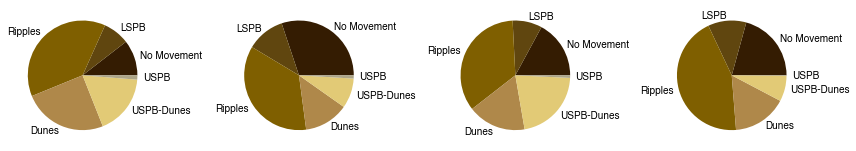

In [160]:
labels = ['No Movement', 'LSPB', 'Ripples', 'Dunes', 'USPB-Dunes', 'USPB']
sand_sizes = xs_percents[:, sandiest_section]*100
mud_sizes = xs_percents[:, muddiest_section]*100
e_time = ts_percents[:, early_time]*100
l_time = ts_percents[:, late_time]*100

    
fig, ax = plt.subplots(1,4, figsize = (12, 6), tight_layout = True)
sandiestpie = ax[0].pie(sand_sizes, labels = labels, colors = clist);
muddiestpie = ax[1].pie(mud_sizes, labels = labels, colors = clist)
earliestpie = ax[2].pie(e_time, labels = labels, colors = clist)
latestpie = ax[3].pie(l_time, labels = labels, colors = clist)

plt.savefig(f'{savefilesto}pies.png', dpi = 200)